<a href="https://colab.research.google.com/github/michiWS1920/nfl_data/blob/michi/TDpredModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
library(tidyverse)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
install.packages(c("tidymodels", "workflows", "tune", "ranger", "glmnet"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘listenv’, ‘prodlim’, ‘future’, ‘plyr’, ‘DiceDesign’, ‘globals’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘pROC’, ‘lhs’, ‘iterators’, ‘dials’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘yardstick’, ‘hardhat’, ‘GPfit’, ‘foreach’, ‘RcppEigen’, ‘shape’




In [4]:
library(tidymodels)
library(workflows)
library(tune)

── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.8      ✔ rsample   0.0.7 
✔ infer     0.5.3      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.1.3 
✔ parsnip   0.1.3      ✔ yardstick 0.0.7 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()



In [5]:
pbp_all <- readRDS("NFLdata.rds")

In [6]:
pbp_all_rp <- pbp_all %>%
      filter(!is.na(epa), !is.na(posteam), play_type=="no_play" | play_type=="pass" | play_type=="run") %>% #filter out certain NA values, only show three play_types
	mutate( #create new columns that indicates if the play was a pass or rush - this is done by parsing the description of the play (certain keywords are perfect indicators)
	pass = if_else(str_detect(desc, "( pass)|(sacked)|(scramble)"), 1, 0), #
	rush = if_else(str_detect(desc, "(left end)|(left tackle)|(left guard)|(up the middle)|(right guard)|(right tackle)|(right end)") & pass == 0, 1, 0),
	success = ifelse(epa>0, 1 , 0),
	passer_player_name = ifelse(play_type == "no_play" & pass == 1, #create new column that parses the player_name depending on the type of play (pass / receiver / rusher)
              str_extract(desc, "(?<=\\s)[A-Z][a-z]*\\.\\s?[A-Z][A-z]+(\\s(I{2,3})|(IV))?(?=\\s((pass)|(sack)|(scramble)))"),
              passer_player_name),
        receiver_player_name = ifelse(play_type == "no_play" & str_detect(desc, "pass"), 
              str_extract(desc, "(?<=to\\s)[A-Z][a-z]*\\.\\s?[A-Z][A-z]+(\\s(I{2,3})|(IV))?"),
              receiver_player_name),
        rusher_player_name = ifelse(play_type == "no_play" & rush == 1, 
              str_extract(desc, "(?<=\\s)[A-Z][a-z]*\\.\\s?[A-Z][A-z]+(\\s(I{2,3})|(IV))?(?=\\s((left end)|(left tackle)|(left guard)|		      (up the middle)|(right guard)|(right tackle)|(right end)))"),
              rusher_player_name),
	name = ifelse(!is.na(passer_player_name), passer_player_name, rusher_player_name),
	yards_gained=ifelse(play_type=="no_play",NA,yards_gained), # filter out NA for yards_gained
	play=1
	) 

In [ ]:
pbp_all_rp %>%
filter(season == 2019 | season == 2018) -> pbp_season
glimpse(pbp_season)

In [43]:
pbp_season$touchdown <- as.factor(pbp_season$touchdown)

In [44]:
set.seed(42)

nfl_split <- initial_split(pbp_season, prop = 3/4)

nfl_split

<Analysis/Assess/Total>
<54303/18100/72403>

In [45]:
nfl_training = training(nfl_split)
nfl_test = training(nfl_split)

In [46]:
nfl_cv = vfold_cv(nfl_training)

In [47]:
recipe(touchdown ~ posteam + defteam + ydstogo + qtr + down + 
        yardline_100 + play_type + game_seconds_remaining + game_half +
         posteam_score + defteam_score + score_differential + wp + def_wp +
         week + epa + air_yards, data =pbp_season) -> nfl_recipe

In [48]:
summary(nfl_recipe)

variable,type,role,source
<chr>,<chr>,<chr>,<chr>
posteam,nominal,predictor,original
defteam,nominal,predictor,original
ydstogo,numeric,predictor,original
qtr,numeric,predictor,original
down,numeric,predictor,original
yardline_100,numeric,predictor,original
play_type,nominal,predictor,original
game_seconds_remaining,numeric,predictor,original
game_half,nominal,predictor,original


In [49]:
nfl_recipe_steps <- nfl_recipe %>%
  step_meanimpute(all_numeric())

In [50]:
nfl_prepped <- prep(nfl_recipe_steps, training = nfl_training)

In [51]:
nfl_prepped

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         17

Training data contained 54303 data points and 27888 incomplete rows. 

Operations:

Mean Imputation for ydstogo, qtr, down, ... [trained]

In [52]:
nfl_training_prep <- bake(nfl_prepped, nfl_training)
nfl_training_prep

posteam,defteam,ydstogo,qtr,down,yardline_100,play_type,game_seconds_remaining,game_half,posteam_score,defteam_score,score_differential,wp,def_wp,week,epa,air_yards,touchdown
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
ATL,PHI,15,1,1,80,pass,3600,Half1,0,0,0,0.4789909,0.5210091,1,0.81834350,8.000000,0
ATL,PHI,5,1,2,70,run,3562,Half1,0,0,0,0.5051000,0.4949000,1,1.36250678,8.122393,0
ATL,PHI,10,1,1,59,run,3526,Half1,0,0,0,0.5483767,0.4516233,1,1.34379984,8.122393,0
ATL,PHI,10,1,1,39,pass,3490,Half1,0,0,0,0.5939910,0.4060090,1,-0.52205267,4.000000,0
ATL,PHI,10,1,3,39,pass,3481,Half1,0,0,0,0.5500403,0.4499597,1,3.29840485,24.000000,0
ATL,PHI,6,1,1,6,run,3435,Half1,0,0,0,0.6635976,0.3364024,1,0.58545190,8.122393,0
ATL,PHI,1,1,3,1,pass,3359,Half1,0,0,0,0.6700005,0.3299995,1,-2.01438265,1.000000,0
PHI,ATL,10,1,1,98,run,3351,Half1,0,0,0,0.4476975,0.5523025,1,-0.42577767,8.122393,0
PHI,ATL,4,1,3,92,pass,3264,Half1,0,0,0,0.4353245,0.5646755,1,-1.13654986,6.000000,0


pass_location 2 many NA's

In [53]:
nfl_test_prep <- bake(nfl_prepped, nfl_test)

In [54]:
rand_forest() %>%
set_args(mtry = tune(),
          trees = tune()) %>%
set_engine("ranger", importance = "impurity") %>%
set_mode("classification") -> rf_model

In [55]:
rf_workflow <- workflow() %>%
  add_recipe(nfl_prepped) %>%
  add_model(rf_model)

In [24]:
expand.grid(mtry = c(3,4,5), trees = c(25, 50, 100))

mtry,trees
<dbl>,<dbl>
3,25
4,25
5,25
3,50
4,50
5,50
3,100
4,100
5,100


In [56]:
rf_grid <- expand.grid(mtry = c(3,4,5), trees = c(25,50,100))

rf_workflow %>%
tune_grid(resamples = nfl_cv,
            grid = rf_grid,
            metrics = metric_set(accuracy, roc_auc)) -> rf_tune_results

In [57]:
rf_tune_results %>%
  collect_metrics()

mtry,trees,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>
3,25,accuracy,binary,0.9941624,10,3.950063e-04,Model1
3,25,roc_auc,binary,0.9982567,10,4.444981e-04,Model1
4,25,accuracy,binary,0.9955620,10,3.604534e-04,Model2
4,25,roc_auc,binary,0.9993328,10,7.366645e-05,Model2
5,25,accuracy,binary,0.9961512,10,2.682096e-04,Model3
5,25,roc_auc,binary,0.9990065,10,3.466828e-04,Model3
3,50,accuracy,binary,0.9944939,10,3.444609e-04,Model4
3,50,roc_auc,binary,0.9987883,10,3.246478e-04,Model4
4,50,accuracy,binary,0.9960039,10,2.516319e-04,Model5


In [58]:
rf_tune_results %>%
  select_best(metric = "roc_auc") -> param_final

  param_final

rf_workflow %>%
  finalize_workflow(param_final) -> rf_workflow

mtry,trees,.config
<dbl>,<dbl>,<fct>
5,100,Model9


In [59]:
rf_workflow %>%
  last_fit(nfl_split) -> rf_fit

In [60]:
test_performance <- rf_fit %>% collect_metrics()
test_performance

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9962983
roc_auc,binary,0.9994840


In [61]:
final_nfl_model <- fit(rf_workflow, pbp_season)
final_nfl_model

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: rand_forest()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

● step_meanimpute()

── Model ───────────────────────────────────────────────────────────────────────
Ranger result

Call:
 ranger::ranger(formula = ..y ~ ., data = data, mtry = ~5, num.trees = ~100,      importance = ~"impurity", num.threads = 1, verbose = FALSE,      seed = sample.int(10^5, 1), probability = TRUE) 

Type:                             Probability estimation 
Number of trees:                  100 
Sample size:                      72403 
Number of independent variables:  17 
Mtry:                             5 
Target node size:                 10 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.003005442 

In [71]:
saveRDS(final_nfl_model, "final_nfl_model.rds")

In [72]:
final_model <- fit(rf_workflow, pbp_season)


ranger_obj <- pull_workflow_fit(final_model)$fit
ranger_obj

Ranger result

Call:
 ranger::ranger(formula = ..y ~ ., data = data, mtry = ~5, num.trees = ~100,      importance = ~"impurity", num.threads = 1, verbose = FALSE,      seed = sample.int(10^5, 1), probability = TRUE) 

Type:                             Probability estimation 
Number of trees:                  100 
Sample size:                      72403 
Number of independent variables:  17 
Mtry:                             5 
Target node size:                 10 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.002994398 

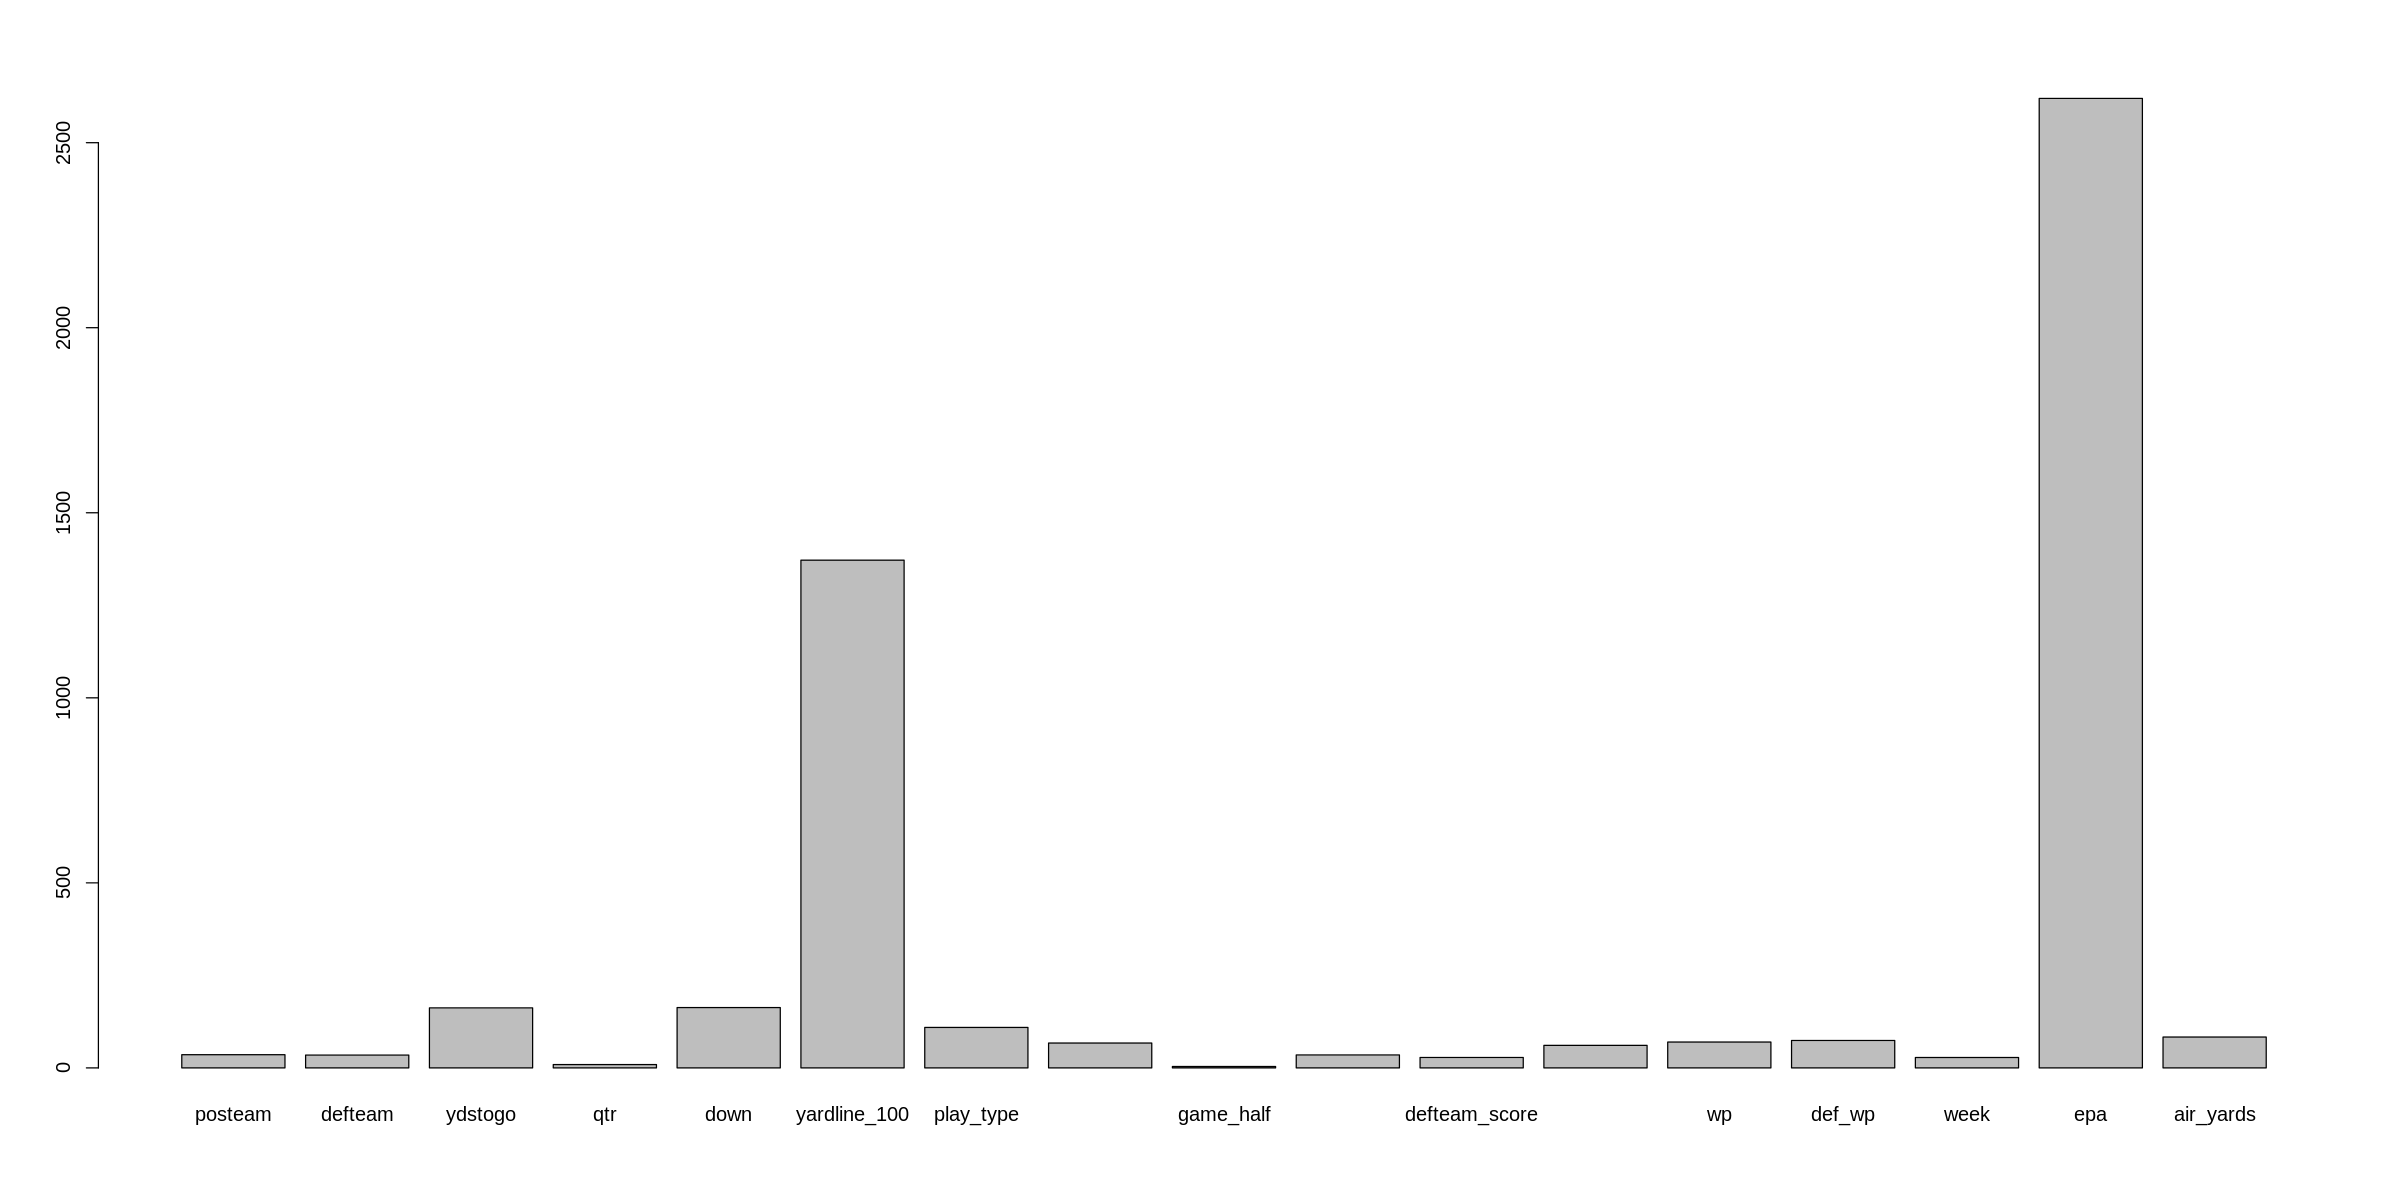

In [74]:
options(repr.plot.width=20, repr.plot.height=10)


barplot(ranger_obj$variable.importance)

* Model is 2 good because of EPA as variable.